In [145]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import itertools
import seaborn as sns
import ast
import os

os.makedirs("plots", exist_ok=True)

In [146]:
# Read Data
file_path = "data/Cleaned_Coding_Schema.xlsx"
data = pd.read_excel(file_path, na_values=[""], keep_default_na=False)

data = data[data['ID'].notna()]

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

print(data)

        ID Bearbeiter 1 Bearbeiter 2                                              Title                                            Authors                                           DOI    Jahr                                              Track                                           Keywords                                  Research question Paper license model                                  Goal of the paper                            Motivation of the Paper                               Outcome of the Paper Type of paper                Type of inquiry 1                Type of inquiry 2                   BPM Lifecycle 1  BPM Lifecycle 2  BPM Lifecycle 3 New Artefact Introduced Theory         Type of Theory  Emphasis Formal concepts Algorithms         Hypothesis                              Independent Variables                                Dependent Variables Type of Artefact 1 Artefact success Reference             Research Method 1             Research Method 2  \
0      1.0  

In [147]:
columns_to_remove = [
    'Paper license model', 'BPM Lifecycle 1', 'BPM Lifecycle 2',
    'BPM Lifecycle 3', 'New Artefact Introduced', 'Theory',
    'Artefact success', 'Reference', 'Data format 1', 'Data format 2',
    'Data License', 'Artefact success.1', 'Reference.1',
    'Type of paper', 'Data License.1'
]
data = data.drop(columns=columns_to_remove, errors='ignore')

header_columns = list(data.columns)
print(header_columns)

['ID', 'Bearbeiter 1', 'Bearbeiter 2', 'Title', 'Authors', 'DOI', 'Jahr', 'Track', 'Keywords', 'Research question', 'Goal of the paper', 'Motivation of the Paper', 'Outcome of the Paper', 'Type of inquiry 1', 'Type of inquiry 2', 'Type of Theory', 'Emphasis', 'Formal concepts', 'Algorithms', 'Hypothesis', 'Independent Variables', 'Dependent Variables', 'Type of Artefact 1', 'Research Method 1', 'Research Method 2', 'Research Method 3', 'Research Method 4', 'Type of data', 'Total participants count', 'Students Count', 'Practitioners Count', 'Data accessibility', 'Data Metadata', 'Material accessibility', 'Evaluation Method 1', 'Evaluation Method 2', 'Evaluation Method 3', 'Evaluation Method 4', 'Threats to Validity 1', 'Threats to Validity 2', 'Threats to Validity 3', 'Threats to Validity 4', 'Existence', 'Availability', 'Type of Artefact 2', 'Research Method 1.1', 'Research Method 2.1', 'Research Method 3.1', 'Research Method 4.1', 'Type of data.1', 'Total participants count.1', 'Stude

In [148]:
def consolidate_columns(data, column_groups):
    """
    Consolidates column values into a list and replaces them with a new column at the original position.

    :param data: DataFrame to be modified.
    :param column_groups: List of dictionaries defining the groups of columns to consolidate.
                          Each dictionary should contain:
                          - 'columns': List of columns to consolidate.
                          - 'new_column': Name of the new consolidated column.
    :return: Modified DataFrame.
    """
    for group in column_groups:
        columns = group['columns']
        new_column = group['new_column']

        # Combine the values of the specified columns into a list
        data[new_column] = data[columns].apply(
            lambda row: list(dict.fromkeys([  # Use dict.fromkeys to remove duplicates
                "None" if value is None or str(value).strip().lower() == "none" else value  # Normalize None values
                for value in row if value != []  # Ignore empty lists
            ])),
            axis=1
        )

        # Insert the new column at the position of the first column in the group
        insert_position = data.columns.get_loc(columns[0])
        data.insert(insert_position, new_column, data.pop(new_column))

        # Drop the original columns
        data = data.drop(columns=columns)

    return data


# Define column groups for consolidation
column_groups = [
    {
        'columns': ['Research Method 1', 'Research Method 2', 'Research Method 3', 'Research Method 4'],
        'new_column': 'Research Method A1'
    },
    {
        'columns': ['Evaluation Method 1', 'Evaluation Method 2', 'Evaluation Method 3', 'Evaluation Method 4'],
        'new_column': 'Evaluation Method A1'
    },
    {
        'columns': ['Threats to Validity 1', 'Threats to Validity 2', 'Threats to Validity 3', 'Threats to Validity 4'],
        'new_column': 'Threats to Validity A1'
    },
    {
        'columns': ['Research Method 1.1', 'Research Method 2.1', 'Research Method 3.1', 'Research Method 4.1'],
        'new_column': 'Research Method A2'
    },
    {
        'columns': ['Evaluation Method 1.1', 'Evaluation Method 2.1', 'Evaluation Method 3.1', 'Evaluation Method 4.1'],
        'new_column': 'Evaluation Method A2'
    },
    {
        'columns': ['Threats to Validity 1.1', 'Threats to Validity 2.1', 'Threats to Validity 3.1', 'Threats to Validity 4.1'],
        'new_column': 'Threats to Validity A2'
    }
]

# Apply the consolidation
data = consolidate_columns(data, column_groups)

print(data.head(1))

    ID Bearbeiter 1 Bearbeiter 2                                              Title                                     Authors                                          DOI    Jahr       Track                                           Keywords Research question                                  Goal of the paper                            Motivation of the Paper                               Outcome of the Paper                Type of inquiry 1 Type of inquiry 2 Type of Theory Emphasis Formal concepts Algorithms Hypothesis Independent Variables Dependent Variables Type of Artefact 1   Research Method A1     Type of data Total participants count  Students Count Practitioners Count  Data accessibility Data Metadata Material accessibility                          Evaluation Method A1 Threats to Validity A1 Existence Availability Type of Artefact 2                   Research Method A2   Type of data.1 Total participants count.1  Students Count.1 Practitioners Count.1 Data format  \
0  1.0  

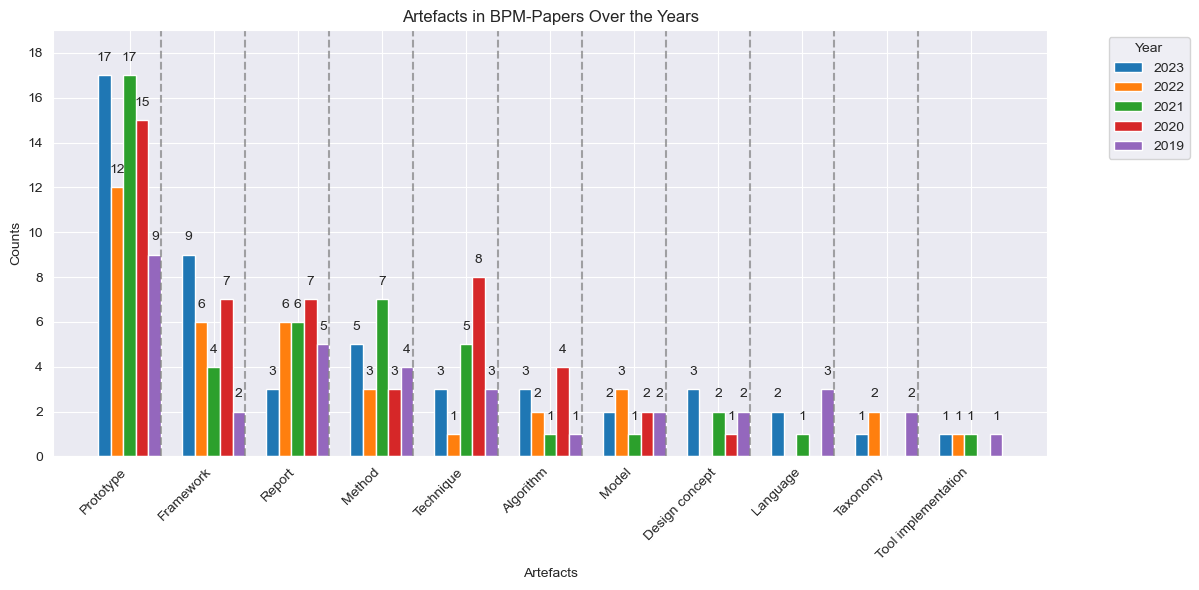

In [149]:
# Artefacts to analyze
artefacts = [
    "Algorithm", "Tool implementation", "Prototype", "Method",
    "Technique", "Language", "Design concept", "Framework",
    "Taxonomy", "Model", "Report"
]

# Create a Counter dictionary to store counts per artefact per year
artefact_year_counts = {artefact: Counter() for artefact in artefacts}

# Count occurrences of artefacts in 'Type of Artefact 1' and 'Type of Artefact 2'
for col in ['Type of Artefact 1', 'Type of Artefact 2']:
    for _, row in data.dropna(subset=[col, 'Jahr']).iterrows():
        artefact = row[col]
        year = int(row['Jahr'])  # Ensure year is an integer
        if artefact in artefacts:
            artefact_year_counts[artefact][year] += 1

# Count artefact mentions in 'Comments'
for _, row in data.dropna(subset=['Comments', 'Jahr']).iterrows():
    comment = row['Comments']
    year = int(row['Jahr'])  # Ensure year is an integer
    for artefact in artefacts:
        if artefact.lower() in comment.lower():
            artefact_year_counts[artefact][year] += 1

# Convert to DataFrame for easier plotting
df_counts = pd.DataFrame(artefact_year_counts).fillna(0).astype(int)
df_counts = df_counts.T  # Transpose to have artefacts as index and years as columns

# Sort artefacts by total occurrences
df_counts['Total'] = df_counts.sum(axis=1)
df_counts = df_counts.sort_values(by='Total', ascending=False).drop(columns=['Total'])

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15  # Width of each bar
years = [int(y) for y in df_counts.columns.tolist()]  # Convert years to int if necessary
x = np.arange(len(df_counts))  # X positions for artefacts

# Define colors for years
colors = plt.cm.tab10.colors[:len(years)]  # Choose distinct colors

# Plot bars for each year
max_height = 0  # Track the maximum bar height
for i, year in enumerate(years):
    bars = ax.bar(x + i * bar_width, df_counts[year], width=bar_width, label=year, color=colors[i])

    # Add labels above bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{int(height)}", ha="center", va="bottom", fontsize=10)
        max_height = max(max_height, height)

# Adjust y-axis limit to make space for labels
ax.set_ylim(0, int(max_height * 1.1) + 1)
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure only integer ticks

# Set dashed lines after the last bar of each group
num_groups = len(df_counts)
for group_index in range(num_groups - 1):  # Do not add a line after the last group
    last_bar_position = x[group_index] + (len(years) - 1) * bar_width  # Last bar of the group
    ax.axvline(x=last_bar_position + bar_width / 2, linestyle="dashed", color="gray", alpha=0.7)

# Add labels
ax.set_xticks(x + (len(years) - 1) * bar_width / 2)
ax.set_xticklabels(df_counts.index, rotation=45, ha="right")
ax.set_xlabel("Artefacts")
ax.set_ylabel("Counts")
ax.set_title("Artefacts in BPM-Papers Over the Years")
ax.legend(title="Year", loc="upper right", bbox_to_anchor=(1.15, 1))

plt.tight_layout()
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

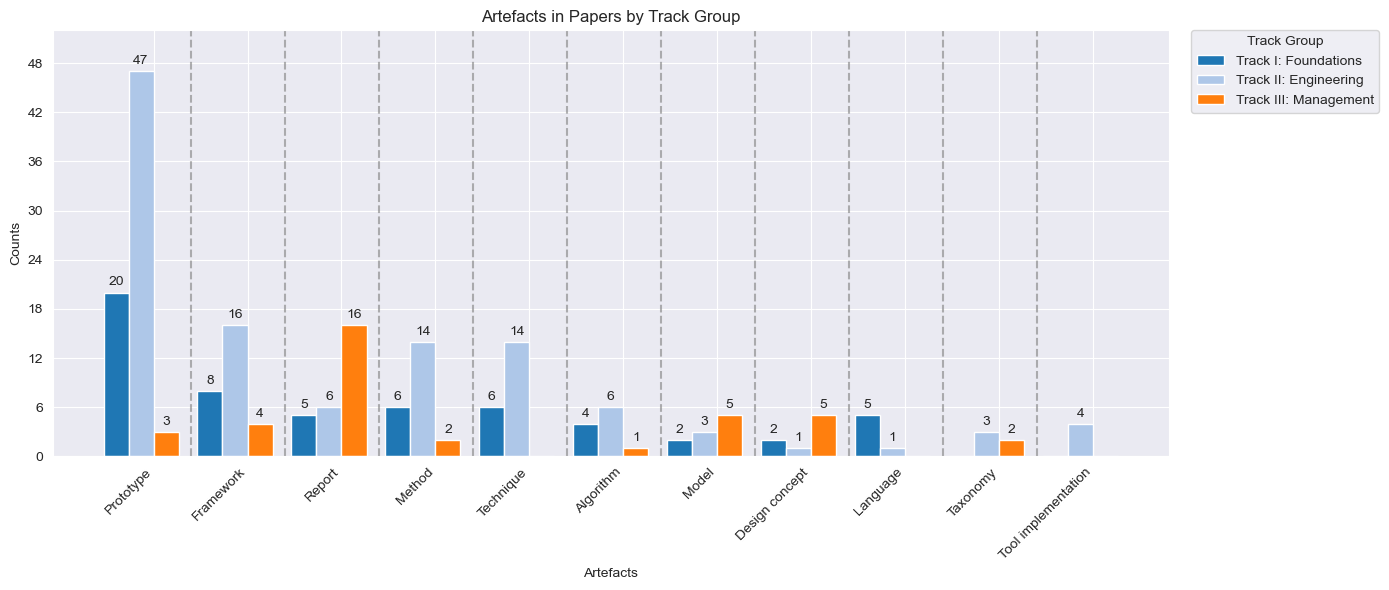

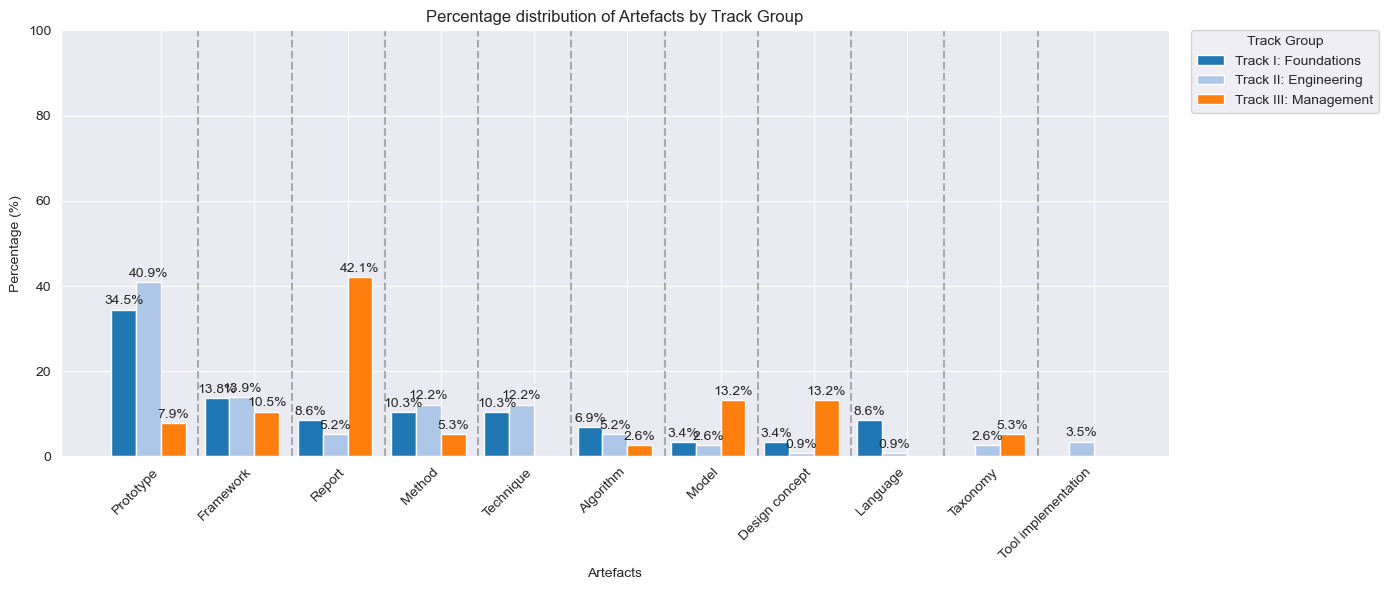

In [150]:
# Define track groups
track_groups = {
    "Track I: Foundations": [
        "Foundation", "Foundations", "Blockchain and Robotic Process Automation",
        "Data- and Time-awareness in BPM", "Concept Drift and Anomaly Detection from Event Logs",
        "Design Methods"
    ],
    "Track II: Engineering": [
        "Engineering", "Analytics", "Process Mining", "Process and Resource Analytics",
        "Task Mining", "Process Mining Practice", "Systems", "Process Discovery",
        "Predictive Process Monitoring", "Conformance Checking"
    ],
    "Track III: Management": [
        "Management", "Digital Innovation and Process Improvement"
    ]
}

# Artefacts to analyze
artefacts = [
    "Algorithm", "Tool implementation", "Prototype", "Method",
    "Technique", "Language", "Design concept", "Framework",
    "Taxonomy", "Model", "Report"
]

# Create Counter dictionary to store counts per artefact per track group
artefact_track_counts = {artefact: Counter() for artefact in artefacts}

# Helper function to assign tracks to groups
def get_track_group(track_name):
    for group, tracks in track_groups.items():
        if track_name in tracks:
            return group
    return "Other"  # If the track does not belong to a defined group

# Count occurrences of artefacts in 'Type of Artefact 1' and 'Type of Artefact 2'
for col in ['Type of Artefact 1', 'Type of Artefact 2']:
    for _, row in data.dropna(subset=[col, 'Track']).iterrows():
        artefact = row[col]
        track_group = get_track_group(row['Track'])  # Assign track to a group
        if artefact in artefacts:
            artefact_track_counts[artefact][track_group] += 1

# Count artefact mentions in 'Comments'
for _, row in data.dropna(subset=['Comments', 'Track']).iterrows():
    comment = row['Comments']
    track_group = get_track_group(row['Track'])  # Assign track to a group
    for artefact in artefacts:
        if artefact.lower() in comment.lower():
            artefact_track_counts[artefact][track_group] += 1

# Convert to DataFrame for easier plotting
df_counts = pd.DataFrame(artefact_track_counts).fillna(0).astype(int)
df_counts = df_counts.T  # Transpose to have artefacts as index and track groups as columns

df_counts['Total'] = df_counts.sum(axis=1)
df_counts = df_counts.sort_values(by='Total', ascending=False).drop(columns=['Total'])

# Plot grouped bar chart (absolute counts)
fig, ax = plt.subplots(figsize=(len(df_counts) * 1.5, 6))  # Adjust figure width dynamically

bar_width = 0.8 / len(df_counts.columns)  # Dynamically adjust bar width
tracks = df_counts.columns.tolist()
x = np.arange(len(df_counts))

# Ensure unique colors for all tracks using itertools cycle
color_cycle = itertools.cycle(plt.colormaps["tab20"].colors)
colors = {track: next(color_cycle) for track in tracks}

# Plot bars
max_height = 0
for i, track in enumerate(tracks):
    bars = ax.bar(x + i * bar_width - (len(tracks) * bar_width) / 2, df_counts[track],
                  width=bar_width, label=track, color=colors[track])
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{int(height)}", ha="center", va="bottom", fontsize=10)
        max_height = max(max_height, height)

# Dashed lines between artefacts
for i in range(len(x) - 1):
    last_bar_pos = x[i] + (len(tracks) - 1) * bar_width / 2
    ax.axvline(x=last_bar_pos + bar_width / 2, linestyle="dashed", color="gray", alpha=0.6)

ax.set_ylim(0, int(max_height * 1.1) + 1)
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax.set_xticks(x)
ax.set_xticklabels(df_counts.index, rotation=45, ha="right")
ax.set_xlabel("Artefacts")
ax.set_ylabel("Counts")
ax.set_title("Artefacts in Papers by Track Group")
ax.legend(title="Track Group", loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout(rect=[0, 0, 0.85, 1])
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

# Compute percentage distribution
df_percent = df_counts.div(df_counts.sum(axis=0), axis=1) * 100

# Plot percentage distribution
fig, ax = plt.subplots(figsize=(len(df_percent) * 1.5, 6))

for i, track in enumerate(tracks):
    bars = ax.bar(x + i * bar_width - (len(tracks) * bar_width) / 2, df_percent[track],
                  width=bar_width, label=track, color=colors[track])
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{height:.1f}%", ha="center", va="bottom", fontsize=10)

# Dashed lines between artefacts
for i in range(len(x) - 1):
    last_bar_pos = x[i] + (len(tracks) - 1) * bar_width / 2
    ax.axvline(x=last_bar_pos + bar_width / 2, linestyle="dashed", color="gray", alpha=0.6)

ax.set_ylim(0, 100)
ax.set_xticks(x)
ax.set_xticklabels(df_percent.index, rotation=45, ha="right")
ax.set_xlabel("Artefacts")
ax.set_ylabel("Percentage (%)")
ax.set_title("Percentage distribution of Artefacts by Track Group")
ax.legend(title="Track Group", loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout(rect=[0, 0, 0.85, 1])
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

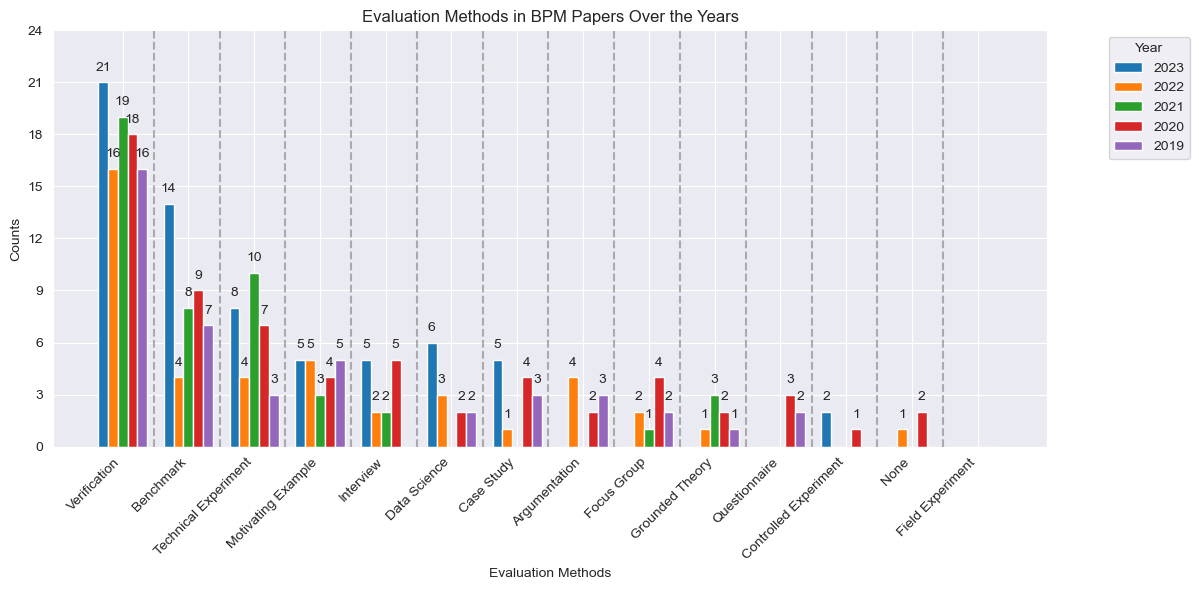

In [151]:
# Updated list of Evaluation Methods
evaluation_methods = [
    "Verification", "Field Experiment", "Benchmark", "Grounded Theory",
    "Argumentation", "Controlled Experiment", "Data Science", "Focus Group",
    "Questionnaire", "Interview", "Motivating Example",
    "Technical Experiment", "Case Study", "None"
]

# Create a Counter dictionary to store counts per evaluation per year
evaluation_year_counts = {evaluation: Counter() for evaluation in evaluation_methods}

# Count occurrences of evaluation in 'Evaluation Method A1' and 'Evaluation Method A2'
for col in ['Evaluation Method A1', 'Evaluation Method A2']:
    for _, row in data.dropna(subset=[col, 'Jahr']).iterrows():
        evaluation = row[col]
        year = int(row['Jahr'])

        if isinstance(evaluation, str) and evaluation.startswith('[') and evaluation.endswith(']'):
            evaluation_list = eval(evaluation)
        elif isinstance(evaluation, list):
            evaluation_list = evaluation
        else:
            evaluation_list = [evaluation]

        for evaluation in evaluation_list:
            if evaluation in evaluation_methods:
                evaluation_year_counts[evaluation][year] += 1

# Count evaluations mentions in 'Comments'
for _, row in data.dropna(subset=['Comments', 'Jahr']).iterrows():
    comment = row['Comments']
    year = int(row['Jahr'])
    for evaluation in evaluation_methods:
        if evaluation.lower() in comment.lower():
            evaluation_year_counts[evaluation][year] += 1

# Convert to DataFrame for easier plotting
df_counts = pd.DataFrame(evaluation_year_counts).fillna(0).astype(int)
df_counts = df_counts.T

# Sort evaluations by total occurrences
df_counts['Total'] = df_counts.sum(axis=1)
df_counts = df_counts.sort_values(by='Total', ascending=False).drop(columns=['Total'])

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
years = [int(y) for y in df_counts.columns.tolist()]
x = np.arange(len(df_counts))

colors = plt.cm.tab10.colors[:len(years)]
max_height = 0

for i, year in enumerate(years):
    bars = ax.bar(x + i * bar_width, df_counts[year], width=bar_width, label=year, color=colors[i])
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{int(height)}", ha="center", va="bottom", fontsize=10)
        max_height = max(max_height, height)

ax.set_ylim(0, int(max_height * 1.1) + 1)
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Dashed lines between evaluation method groups
num_groups = len(df_counts)
for group_index in range(num_groups - 1):
    last_bar_position = x[group_index] + (len(years) - 1) * bar_width
    line_position = last_bar_position + bar_width / 2 + 0.1
    ax.axvline(x=line_position, linestyle="dashed", color="gray", alpha=0.6)

# Labels and title
ax.set_xticks(x + (len(years) - 1) * bar_width / 2)
ax.set_xticklabels(df_counts.index, rotation=45, ha="right")
ax.set_xlabel("Evaluation Methods")
ax.set_ylabel("Counts")
ax.set_title("Evaluation Methods in BPM Papers Over the Years")
ax.legend(title="Year", loc="upper right", bbox_to_anchor=(1.15, 1))

plt.tight_layout()
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()


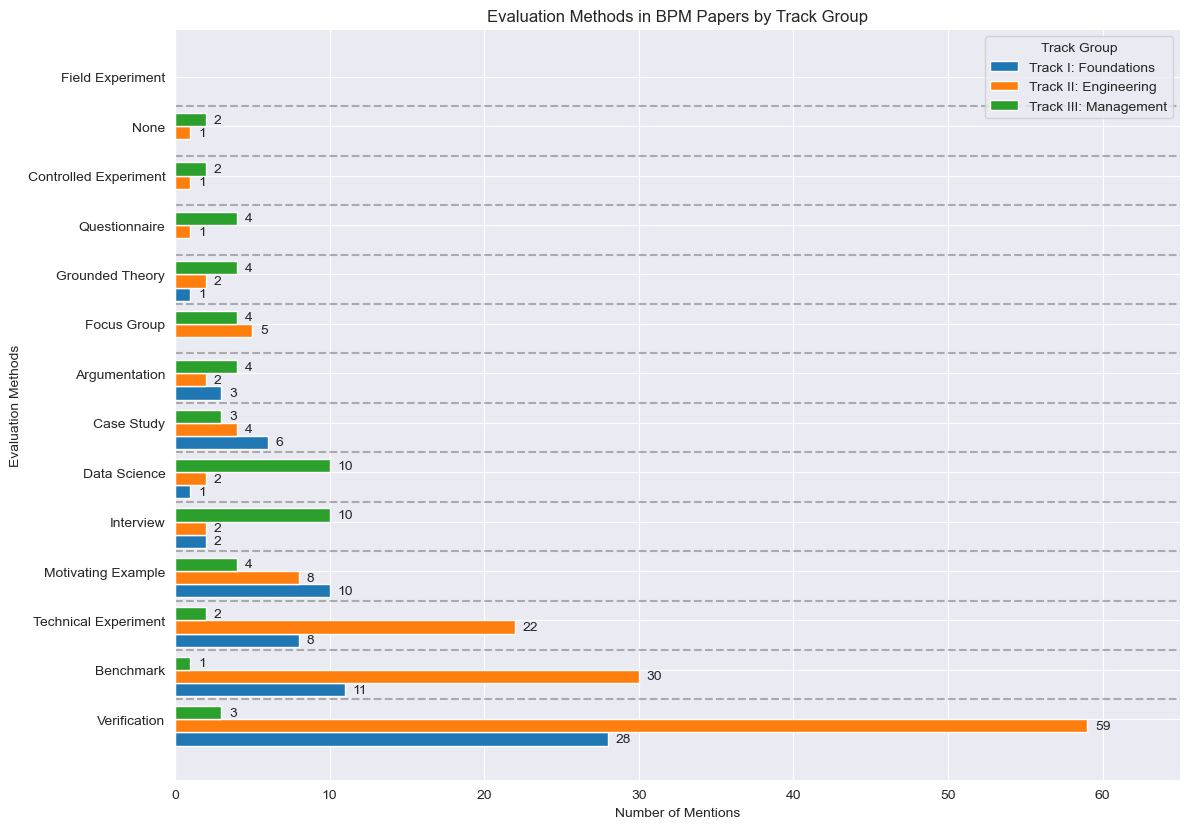

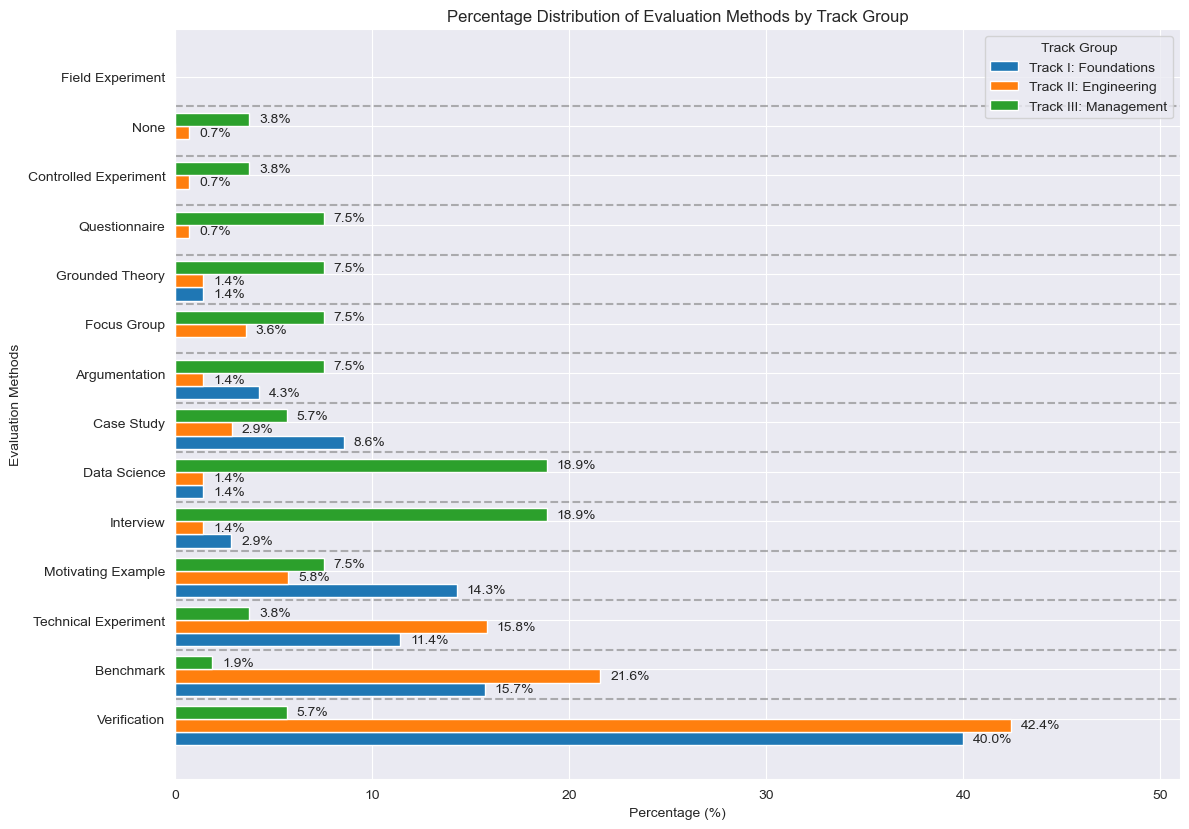

In [152]:
# Mapping of individual tracks to groups
track_groups = {
    "Track I: Foundations": [
        "Foundation", "Foundations", "Blockchain and Robotic Process Automation",
        "Data- and Time-awareness in BPM", "Concept Drift and Anomaly Detection from Event Logs", "Design Methods"
    ],
    "Track II: Engineering": [
        "Engineering", "Analytics", "Process Mining", "Process and Resource Analytics", "Task Mining",
        "Process Mining Practice", "Systems", "Process Discovery", "Predictive Process Monitoring", "Conformance Checking"
    ],
    "Track III: Management": [
        "Management", "Digital Innovation and Process Improvement"
    ]
}

# Reverse mapping
track_mapping = {track: group for group, tracks in track_groups.items() for track in tracks}

# Evaluation methods
evaluation_methods = [
    "Verification", "Field Experiment", "Benchmark", "Grounded Theory", "Argumentation", "Controlled Experiment",
    "Data Science", "Focus Group", "Questionnaire", "Interview", "Motivating Example", "Technical Experiment",
    "Case Study", "None"
]

# Count evaluations per track group
evaluation_track_counts = {evaluation: Counter() for evaluation in evaluation_methods}

# Count methods in columns
for col in ['Evaluation Method A1', 'Evaluation Method A2']:
    for _, row in data.dropna(subset=[col, 'Track']).iterrows():
        evaluation = row[col]
        track = row['Track']
        track_group = track_mapping.get(track)
        if not track_group:
            continue

        if isinstance(evaluation, str) and evaluation.startswith('[') and evaluation.endswith(']'):
            evaluation_list = eval(evaluation)
        elif isinstance(evaluation, list):
            evaluation_list = evaluation
        else:
            evaluation_list = [evaluation]

        for evaluation in evaluation_list:
            if evaluation in evaluation_methods:
                evaluation_track_counts[evaluation][track_group] += 1

# Count mentions in comments
for _, row in data.dropna(subset=['Comments', 'Track']).iterrows():
    comment = row['Comments']
    track = row['Track']
    track_group = track_mapping.get(track)
    if not track_group:
        continue
    for evaluation in evaluation_methods:
        if evaluation.lower() in comment.lower():
            evaluation_track_counts[evaluation][track_group] += 1

df_counts = pd.DataFrame(evaluation_track_counts).fillna(0).astype(int).T
df_counts['Total'] = df_counts.sum(axis=1)
df_counts = df_counts.sort_values(by='Total', ascending=False).drop(columns=['Total'])

# Plot settings
color_cycle = itertools.cycle(plt.colormaps["tab10"].colors)
tracks = df_counts.columns.tolist()
colors = {track: next(color_cycle) for track in tracks}
bar_height = 0.8 / len(tracks)
y = np.arange(len(df_counts))

# -------- Absolute Values --------
fig, ax = plt.subplots(figsize=(12, len(df_counts) * 0.6))
max_width = 0

for i, track in enumerate(tracks):
    bars = ax.barh(
        y + i * bar_height - (len(tracks) * bar_height) / 2,
        df_counts[track],
        height=bar_height,
        label=track,
        color=colors[track]
    )
    for j, bar in enumerate(bars):
        width = bar.get_width()
        if width > 0:
            ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{int(width)}", va="center", ha="left", fontsize=10)
        max_width = max(max_width, width)

# Dashed lines between artefacts
for i in range(len(y) - 1):
    last_bar_y = y[i] + (len(tracks) - 1) * bar_height / 2
    ax.axhline(y=last_bar_y + bar_height / 2, linestyle="dashed", color="gray", alpha=0.6)

ax.set_xlim(0, int(max_width * 1.1) + 1)
ax.set_yticks(y)
ax.set_yticklabels(df_counts.index)
ax.set_ylabel("Evaluation Methods")
ax.set_xlabel("Number of Mentions")
ax.set_title("Evaluation Methods in BPM Papers by Track Group")
ax.legend(title="Track Group", loc="upper right", bbox_to_anchor=(1, 1), frameon=True)

plt.tight_layout()
fig.savefig("plots/Evaluation_methods_horizontal_counts.png", bbox_inches='tight', dpi=300)
plt.show()

# -------- Percent Distribution --------
df_percent = df_counts.div(df_counts.sum(axis=0), axis=1) * 100
fig, ax = plt.subplots(figsize=(12, len(df_percent) * 0.6))
max_percent = 0

for i, track in enumerate(tracks):
    bars = ax.barh(
        y + i * bar_height - (len(tracks) * bar_height) / 2,
        df_percent[track],
        height=bar_height,
        label=track,
        color=colors[track]
    )
    for j, bar in enumerate(bars):
        width = bar.get_width()
        if width > 0:
            ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{width:.1f}%", va="center", ha="left", fontsize=10)
        max_percent = max(max_percent, width)

# Dashed lines between artefacts
for i in range(len(y) - 1):
    last_bar_y = y[i] + (len(tracks) - 1) * bar_height / 2
    ax.axhline(y=last_bar_y + bar_height / 2, linestyle="dashed", color="gray", alpha=0.6)

ax.set_xlim(0, int(max_percent * 1.1) + 5)
ax.set_yticks(y)
ax.set_yticklabels(df_percent.index)
ax.set_ylabel("Evaluation Methods")
ax.set_xlabel("Percentage (%)")
ax.set_title("Percentage Distribution of Evaluation Methods by Track Group")
ax.legend(title="Track Group", loc="upper right", bbox_to_anchor=(1, 1), frameon=True)

plt.tight_layout()
fig.savefig("plots/Evaluation_methods_horizontal_percentages.png", bbox_inches='tight', dpi=300)
plt.show()

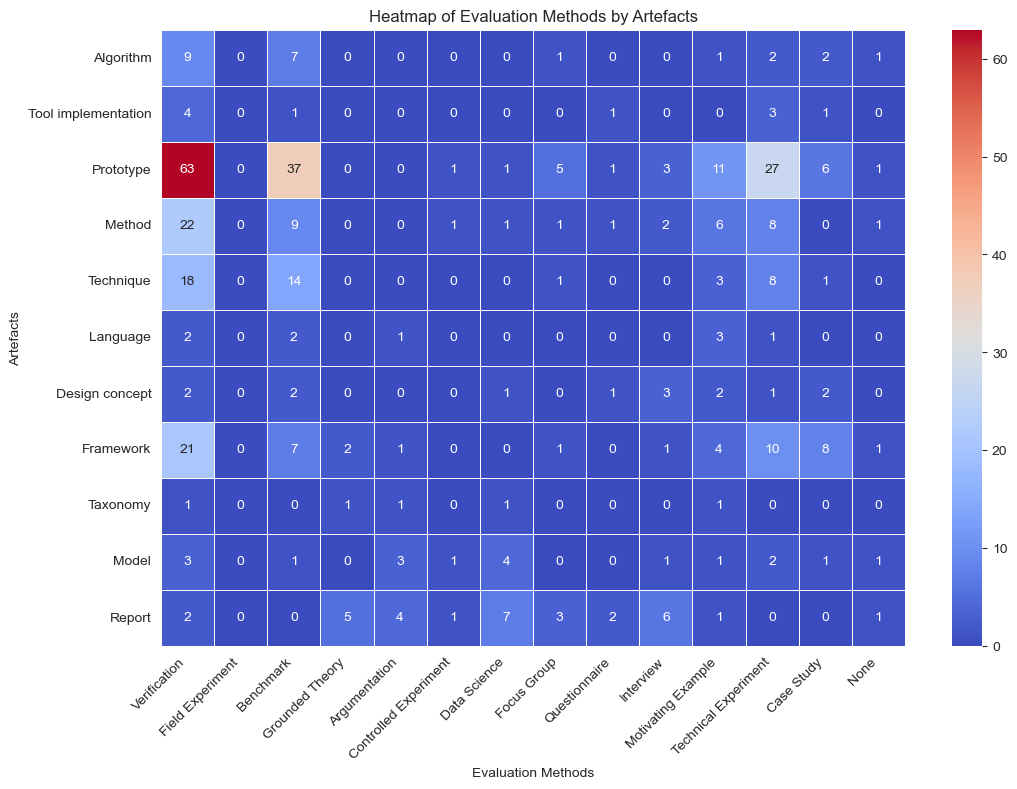

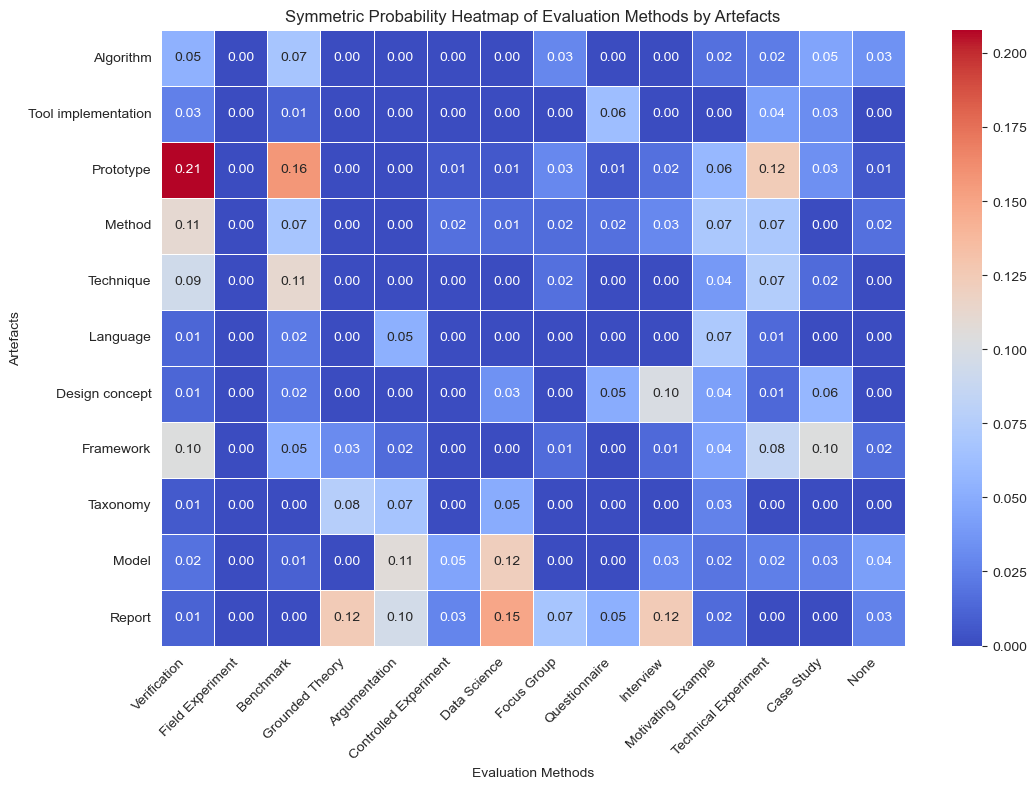

In [153]:
# Define Artefacts and Evaluation Methods
artefacts = [
    "Algorithm", "Tool implementation", "Prototype", "Method",
    "Technique", "Language", "Design concept", "Framework",
    "Taxonomy", "Model", "Report"
]

evaluation_methods = [
    "Verification", "Field Experiment", "Benchmark", "Grounded Theory",
    "Argumentation", "Controlled Experiment", "Data Science", "Focus Group",
    "Questionnaire", "Interview", "Motivating Example",
    "Technical Experiment", "Case Study", "None"
]

# Initialize DataFrames to store counts
heatmap_data = pd.DataFrame(0, index=artefacts, columns=evaluation_methods)
symmetric_probability = pd.DataFrame(0.0, index=artefacts, columns=evaluation_methods)

data_counts_per_method = Counter()

# Count occurrences of each Evaluation Method for each Artefact
for index, row in data.iterrows():
    artefact_entries = set(row[['Type of Artefact 1', 'Type of Artefact 2']].dropna().astype(str))
    eval_methods = set()

    for col in ['Evaluation Method A1', 'Evaluation Method A2']:
        if col in row and isinstance(row[col], (str, list)):
            entry = row[col]
            if isinstance(entry, str) and entry.startswith('[') and entry.endswith(']'):
                try:
                    parsed = ast.literal_eval(entry)
                    eval_methods.update(parsed if isinstance(parsed, list) else [parsed])
                except Exception:
                    eval_methods.add(entry)
            elif isinstance(entry, list):
                eval_methods.update(entry)
            else:
                eval_methods.add(entry)

    # Update the heatmap data
    for artefact in artefact_entries:
        if artefact in artefacts:
            for method in eval_methods:
                if method in evaluation_methods:
                    heatmap_data.at[artefact, method] += 1
                    data_counts_per_method[method] += 1

# Compute symmetric probability
for method in evaluation_methods:
    total_per_method = heatmap_data[method].sum()
    for artefact in artefacts:
        total_per_artefact = heatmap_data.loc[artefact].sum()
        joint_count = heatmap_data.at[artefact, method]

        p_a_given_m = joint_count / total_per_method if total_per_method > 0 else 0
        p_m_given_a = joint_count / total_per_artefact if total_per_artefact > 0 else 0

        if (p_a_given_m + p_m_given_a) > 0:
            symmetric_probability.at[artefact, method] = (p_a_given_m * p_m_given_a) / (p_a_given_m + p_m_given_a)
        else:
            symmetric_probability.at[artefact, method] = 0

# Plot the original Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt="d", linewidths=0.5)
plt.xlabel("Evaluation Methods")
plt.ylabel("Artefacts")
plt.title("Heatmap of Evaluation Methods by Artefacts")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

# Plot the symmetric probability Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(symmetric_probability, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xlabel("Evaluation Methods")
plt.ylabel("Artefacts")
plt.title("Symmetric Probability Heatmap of Evaluation Methods by Artefacts")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

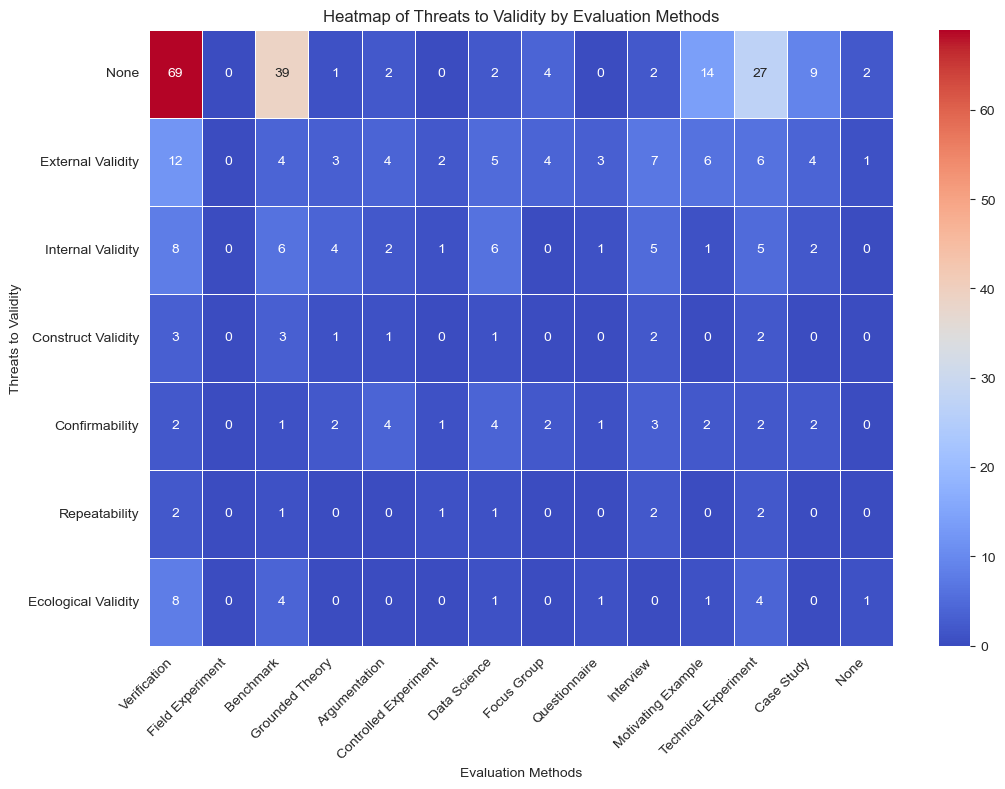

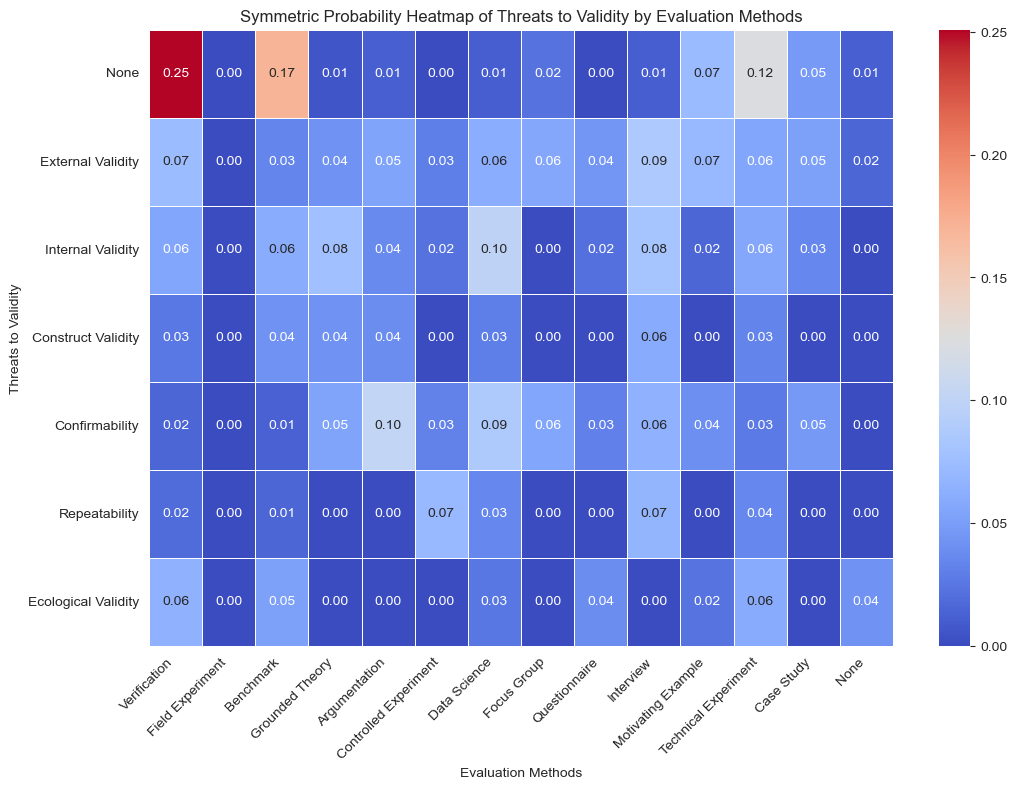

In [154]:
# Define Threats to Validity and Evaluation Methods
validity_threats = [
    "None", "External Validity", "Internal Validity",
    "Construct Validity", "Confirmability", "Repeatability", "Ecological Validity"
]

evaluation_methods = [
    "Verification", "Field Experiment", "Benchmark", "Grounded Theory",
    "Argumentation", "Controlled Experiment", "Data Science", "Focus Group",
    "Questionnaire", "Interview", "Motivating Example",
    "Technical Experiment", "Case Study", "None"
]

# Initialize DataFrames to store counts
heatmap_data = pd.DataFrame(0, index=validity_threats, columns=evaluation_methods)
symmetric_probability = pd.DataFrame(0.0, index=validity_threats, columns=evaluation_methods)

data_counts_per_method = Counter()

# Count occurrences of each Evaluation Method for each Threat to Validity
for index, row in data.iterrows():
    threats = set()
    eval_methods = set()

    for col in ['Threats to Validity A1', 'Threats to Validity A2']:
        if col in row and isinstance(row[col], (str, list)):
            entry = row[col]
            if isinstance(entry, str) and entry.startswith('[') and entry.endswith(']'):
                try:
                    parsed = ast.literal_eval(entry)
                    threats.update(parsed if isinstance(parsed, list) else [parsed])
                except Exception:
                    threats.add(entry)
            elif isinstance(entry, list):
                threats.update(entry)
            else:
                threats.add(entry)

    # Extract evaluation methods
    for col in ['Evaluation Method A1', 'Evaluation Method A2']:
        if col in row and isinstance(row[col], (str, list)):
            entry = row[col]
            if isinstance(entry, str) and entry.startswith('[') and entry.endswith(']'):
                try:
                    parsed = ast.literal_eval(entry)
                    eval_methods.update(parsed if isinstance(parsed, list) else [parsed])
                except Exception:
                    eval_methods.add(entry)
            elif isinstance(entry, list):
                eval_methods.update(entry)
            else:
                eval_methods.add(entry)

    # Update the heatmap data
    for threat in threats:
        if threat in validity_threats:
            for method in eval_methods:
                if method in evaluation_methods:
                    heatmap_data.at[threat, method] += 1
                    data_counts_per_method[method] += 1

# Compute symmetric probability
for method in evaluation_methods:
    total_per_method = heatmap_data[method].sum()
    for threat in validity_threats:
        total_per_threat = heatmap_data.loc[threat].sum()
        joint_count = heatmap_data.at[threat, method]

        p_tv_given_em = joint_count / total_per_method if total_per_method > 0 else 0
        p_em_given_tv = joint_count / total_per_threat if total_per_threat > 0 else 0

        if (p_tv_given_em + p_em_given_tv) > 0:
            symmetric_probability.at[threat, method] = (p_tv_given_em * p_em_given_tv) / (p_tv_given_em + p_em_given_tv)
        else:
            symmetric_probability.at[threat, method] = 0

# Plot the original Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt="d", linewidths=0.5)
plt.xlabel("Evaluation Methods")
plt.ylabel("Threats to Validity")
plt.title("Heatmap of Threats to Validity by Evaluation Methods")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

# Plot the symmetric probability Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(symmetric_probability, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xlabel("Evaluation Methods")
plt.ylabel("Threats to Validity")
plt.title("Symmetric Probability Heatmap of Threats to Validity by Evaluation Methods")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

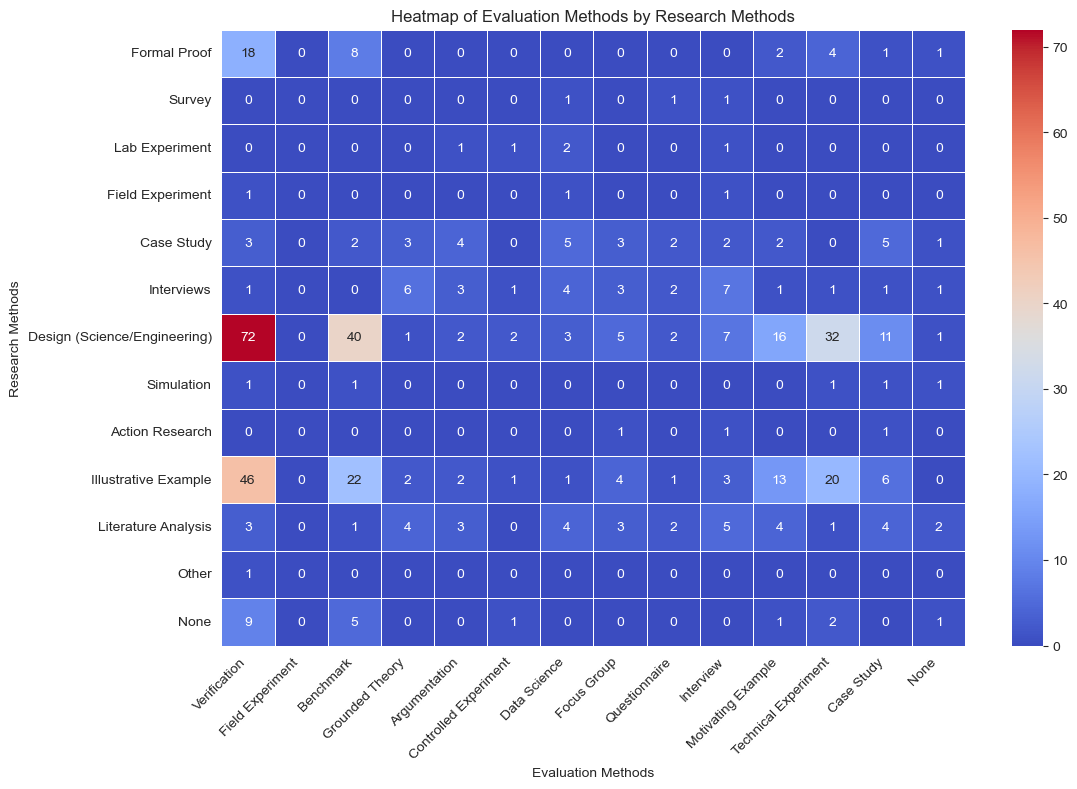

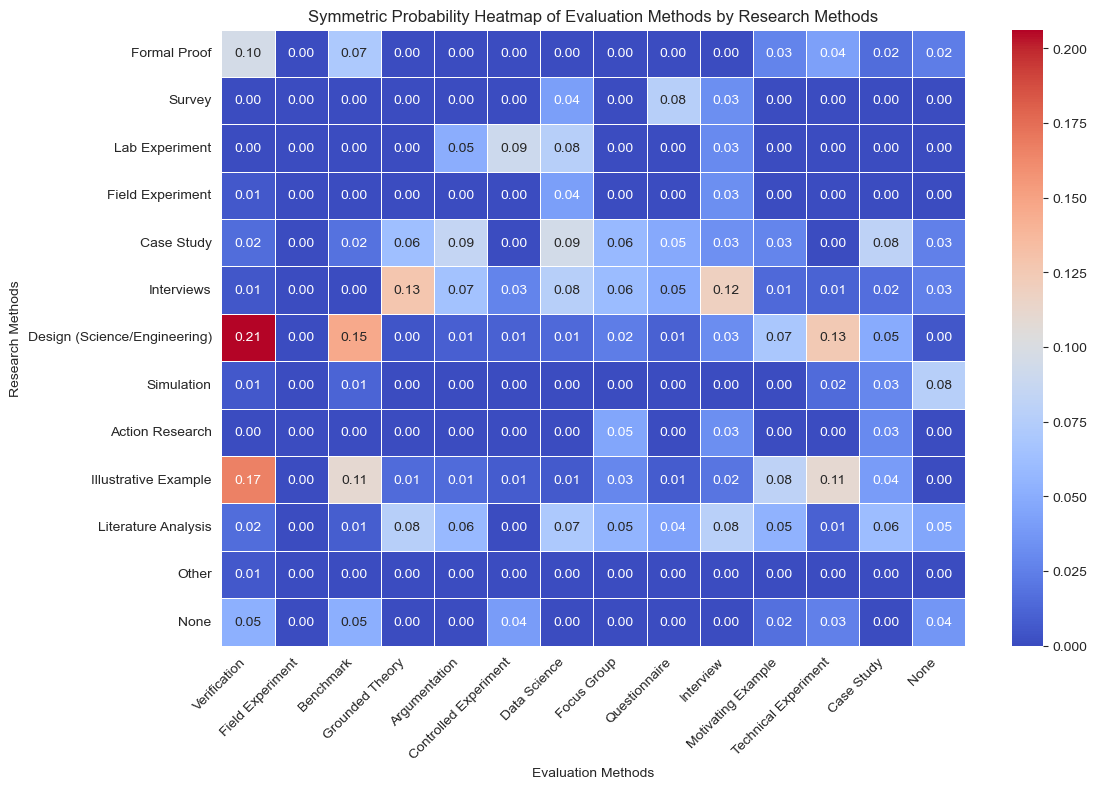

In [155]:
# Define Research Methods and Evaluation Methods
research_methods = [
    "Formal Proof", "Survey", "Lab Experiment", "Field Experiment",
    "Case Study", "Interviews", "Design (Science/Engineering)", "Simulation",
    "Action Research", "Illustrative Example", "Literature Analysis", "Other", "None"
]

evaluation_methods = [
    "Verification", "Field Experiment", "Benchmark", "Grounded Theory",
    "Argumentation", "Controlled Experiment", "Data Science", "Focus Group",
    "Questionnaire", "Interview", "Motivating Example",
    "Technical Experiment", "Case Study", "None"
]

# Initialize DataFrames to store counts
heatmap_data = pd.DataFrame(0, index=research_methods, columns=evaluation_methods)
symmetric_probability = pd.DataFrame(0.0, index=research_methods, columns=evaluation_methods)

data_counts_per_method = Counter()

# Count occurrences of each Evaluation Method for each Research Method
for index, row in data.iterrows():
    research_entries = set()
    eval_methods = set()

    for col in ['Research Method A1', 'Research Method A2']:
        if col in row and isinstance(row[col], (str, list)):
            entry = row[col]
            if isinstance(entry, str) and entry.startswith('[') and entry.endswith(']'):
                try:
                    parsed = ast.literal_eval(entry)
                    research_entries.update(parsed if isinstance(parsed, list) else [parsed])
                except Exception:
                    research_entries.add(entry)
            elif isinstance(entry, list):
                research_entries.update(entry)
            else:
                research_entries.add(entry)

    # Extract evaluation methods
    for col in ['Evaluation Method A1', 'Evaluation Method A2']:
        if col in row and isinstance(row[col], (str, list)):
            entry = row[col]
            if isinstance(entry, str) and entry.startswith('[') and entry.endswith(']'):
                try:
                    parsed = ast.literal_eval(entry)
                    eval_methods.update(parsed if isinstance(parsed, list) else [parsed])
                except Exception:
                    eval_methods.add(entry)
            elif isinstance(entry, list):
                eval_methods.update(entry)
            else:
                eval_methods.add(entry)

    # Update the heatmap data
    for research in research_entries:
        if research in research_methods:
            for method in eval_methods:
                if method in evaluation_methods:
                    heatmap_data.at[research, method] += 1
                    data_counts_per_method[method] += 1

# Compute symmetric probability
for method in evaluation_methods:
    total_per_method = heatmap_data[method].sum()
    for research in research_methods:
        total_per_research = heatmap_data.loc[research].sum()
        joint_count = heatmap_data.at[research, method]

        p_rm_given_em = joint_count / total_per_method if total_per_method > 0 else 0
        p_em_given_rm = joint_count / total_per_research if total_per_research > 0 else 0

        if (p_rm_given_em + p_em_given_rm) > 0:
            symmetric_probability.at[research, method] = (p_rm_given_em * p_em_given_rm) / (p_rm_given_em + p_em_given_rm)
        else:
            symmetric_probability.at[research, method] = 0

# Plot the original Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt="d", linewidths=0.5)
plt.xlabel("Evaluation Methods")
plt.ylabel("Research Methods")
plt.title("Heatmap of Evaluation Methods by Research Methods")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

# Plot the symmetric probability Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(symmetric_probability, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xlabel("Evaluation Methods")
plt.ylabel("Research Methods")
plt.title("Symmetric Probability Heatmap of Evaluation Methods by Research Methods")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

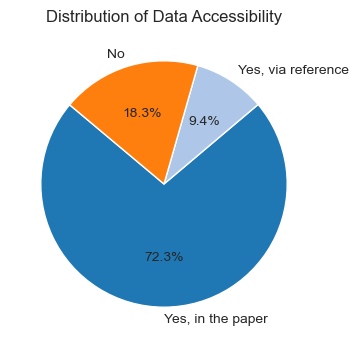

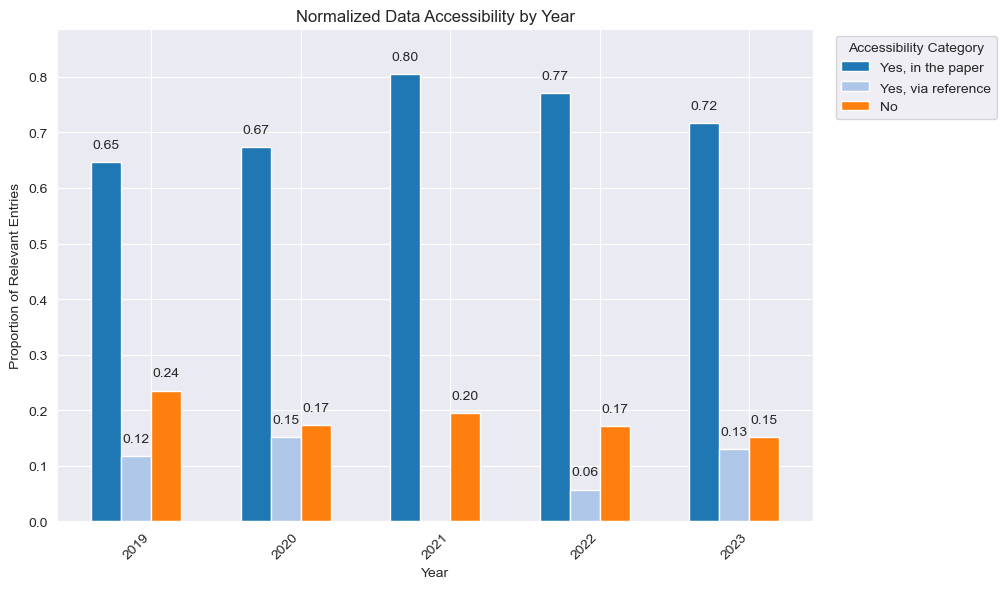

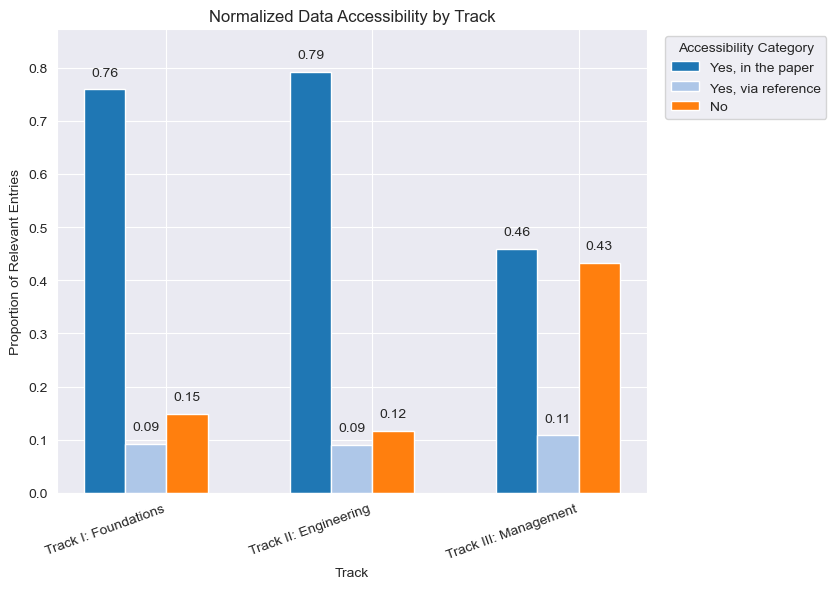

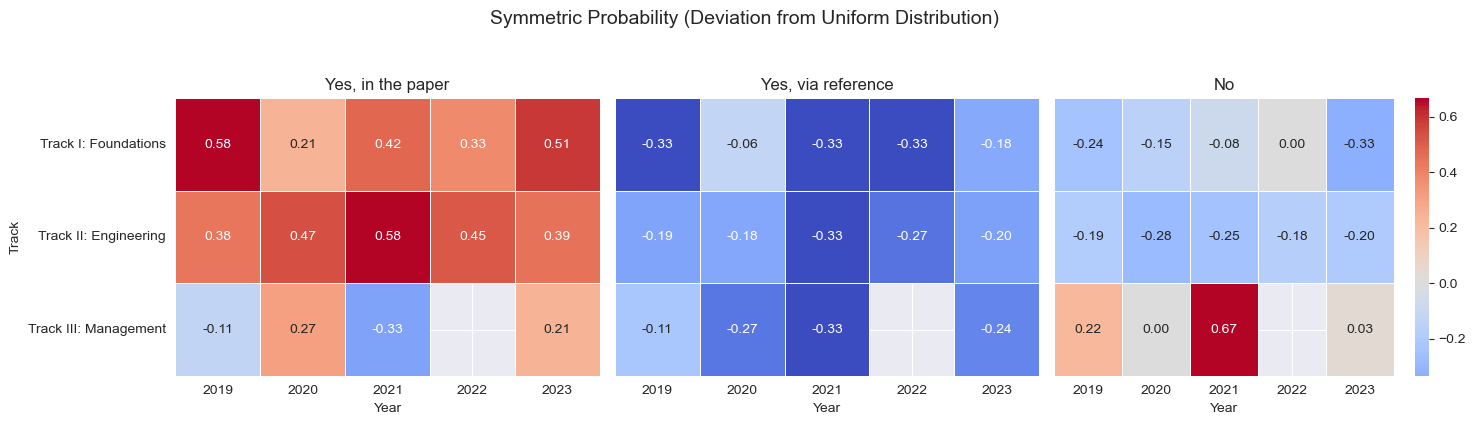

In [156]:
# Categories for data accessibility
accessibility_categories = [
    "Yes, in the paper",
    "Yes, via reference",
    "No"
]

# Color palette for accessibility categories
colors = plt.cm.tab20.colors[:len(accessibility_categories)]

# Mapping of individual tracks to groups
track_groups = {
    "Track I: Foundations": [
        "Foundation", "Foundations", "Blockchain and Robotic Process Automation",
        "Data- and Time-awareness in BPM", "Concept Drift and Anomaly Detection from Event Logs", "Design Methods"
    ],
    "Track II: Engineering": [
        "Engineering", "Analytics", "Process Mining", "Process and Resource Analytics", "Task Mining",
        "Process Mining Practice", "Systems", "Process Discovery", "Predictive Process Monitoring", "Conformance Checking"
    ],
    "Track III: Management": [
        "Management", "Digital Innovation and Process Improvement"
    ]
}

# Reverse mapping from title to track group
title_to_track = {}
for group, titles in track_groups.items():
    for title in titles:
        title_to_track[title] = group

# Count per year
accessibility_year_counts = {category: Counter() for category in accessibility_categories}
total_accessibility_entries_per_year = Counter()

for _, row in data.dropna(subset=['Jahr']).iterrows():
    year = int(row['Jahr'])

    # 'Data accessibility' processing
    if pd.notna(row['Type of data']) and pd.isna(row['Data accessibility']):
        accessibility_year_counts["No"][year] += 1
        total_accessibility_entries_per_year[year] += 1
    elif row['Data accessibility'] in accessibility_categories:
        accessibility_year_counts[row['Data accessibility']][year] += 1
        total_accessibility_entries_per_year[year] += 1

    # 'Data accessibility.1' processing
    if pd.notna(row['Type of data.1']) and pd.isna(row['Data accessibility.1']):
        accessibility_year_counts["No"][year] += 1
        total_accessibility_entries_per_year[year] += 1
    elif row['Data accessibility.1'] in accessibility_categories:
        accessibility_year_counts[row['Data accessibility.1']][year] += 1
        total_accessibility_entries_per_year[year] += 1

# Convert to DataFrame
df_counts = pd.DataFrame(accessibility_year_counts).fillna(0).astype(int).T
df_counts = df_counts[sorted(df_counts.columns)]
df_total_accessibility = pd.DataFrame.from_dict(
    total_accessibility_entries_per_year, orient='index', columns=['Total Accessibility']
).sort_index()
df_normalized = df_counts.div(df_total_accessibility['Total Accessibility'], axis=1).fillna(0)

# Pie Chart (Overall Distribution)
plt.figure(figsize=(4, 4))
total_counts = df_counts.sum(axis=1)
plt.pie(total_counts, labels=accessibility_categories, autopct='%1.1f%%',
        startangle=140, colors=colors)
plt.title("Distribution of Data Accessibility")
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png",
            bbox_inches='tight', dpi=300)
plt.show()

# Bar Chart (by Year, Normalized)
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
years = df_normalized.columns.tolist()
x = np.arange(len(years))

for i, category in enumerate(accessibility_categories):
    bars = ax.bar(x + i * bar_width - (len(accessibility_categories) * bar_width) / 2,
                  df_normalized.loc[category],
                  width=bar_width, label=category, color=colors[i])

    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}",
                    ha="center", va="bottom", fontsize=10)

ax.set_ylim(0, df_normalized.max().max() * 1.1)
ax.set_xticks(x)
ax.set_xticklabels(years, rotation=45, ha="right")
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of Relevant Entries")
ax.set_title("Normalized Data Accessibility by Year")
ax.legend(title="Accessibility Category", loc="upper left", bbox_to_anchor=(1.02, 1))

plt.tight_layout(rect=[0, 0, 0.85, 1])
fig.savefig(f"plots/Normalized_Data_Accessibility_by_Year.png", bbox_inches='tight', dpi=300)
plt.show()

# Bar Chart (by Track, Normalized)

accessibility_track_counts = {category: Counter() for category in accessibility_categories}
total_accessibility_entries_per_track = Counter()

for _, row in data.iterrows():
    track_title = row.get('Track')  # Make sure this column exists or adjust accordingly
    if pd.isna(track_title):
        continue

    track_group = title_to_track.get(track_title)
    if not track_group:
        continue

    if pd.notna(row['Type of data']) and pd.isna(row['Data accessibility']):
        accessibility_track_counts["No"][track_group] += 1
        total_accessibility_entries_per_track[track_group] += 1
    elif row['Data accessibility'] in accessibility_categories:
        accessibility_track_counts[row['Data accessibility']][track_group] += 1
        total_accessibility_entries_per_track[track_group] += 1

    if pd.notna(row['Type of data.1']) and pd.isna(row['Data accessibility.1']):
        accessibility_track_counts["No"][track_group] += 1
        total_accessibility_entries_per_track[track_group] += 1
    elif row['Data accessibility.1'] in accessibility_categories:
        accessibility_track_counts[row['Data accessibility.1']][track_group] += 1
        total_accessibility_entries_per_track[track_group] += 1

df_track_counts = pd.DataFrame(accessibility_track_counts).fillna(0).astype(int).T
ordered_tracks = list(track_groups.keys())
df_track_counts = df_track_counts[ordered_tracks]
df_total_track = pd.Series(total_accessibility_entries_per_track)
df_normalized_track = df_track_counts.div(df_total_track, axis=1).fillna(0)

fig, ax = plt.subplots(figsize=(10, 6))
tracks = df_normalized_track.columns.tolist()
x = np.arange(len(tracks))

for i, category in enumerate(accessibility_categories):
    bars = ax.bar(x + i * bar_width - (len(accessibility_categories) * bar_width) / 2,
                  df_normalized_track.loc[category],
                  width=bar_width, label=category, color=colors[i])

    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}",
                    ha="center", va="bottom", fontsize=10)

ax.set_ylim(0, df_normalized_track.max().max() * 1.1)
ax.set_xticks(x)
ax.set_xticklabels(tracks, rotation=20, ha="right")
ax.set_xlabel("Track")
ax.set_ylabel("Proportion of Relevant Entries")
ax.set_title("Normalized Data Accessibility by Track")
ax.legend(title="Accessibility Category", loc="upper left", bbox_to_anchor=(1.02, 1))

plt.tight_layout(rect=[0, 0, 0.85, 1])
fig.savefig(f"plots/Normalized_Data_Accessibility_by_Track.png", bbox_inches='tight', dpi=300)
plt.show()

# Prepare DataFrame for heatmap (Track x Year x Category → Value)
heatmap_data = []

for (track, year), total in total_entries_per_track_year.items():
    if total == 0:
        continue
    for category in accessibility_categories:
        count = accessibility_track_year_counts[category].get((track, year), 0)
        proportion = count / total
        sym_p = proportion - 1 / len(accessibility_categories)  # subtract uniform prob
        heatmap_data.append({
            "Track": track,
            "Year": year,
            "Category": category,
            "SymmetricProbability": sym_p
        })

df_heatmap = pd.DataFrame(heatmap_data)

# Pivot and plot: one heatmap per category (symmetrically normalized)
fig, axes = plt.subplots(1, len(accessibility_categories), figsize=(5 * len(accessibility_categories), 4), sharey=True)

for i, category in enumerate(accessibility_categories):
    ax = axes[i]
    df_cat = df_heatmap[df_heatmap["Category"] == category]
    pivot = df_cat.pivot(index="Track", columns="Year", values="SymmetricProbability").reindex(index=tracks, columns=years)

    sns.heatmap(pivot, annot=True, fmt=".2f", center=0, cmap="coolwarm", cbar=(i == len(accessibility_categories)-1),
                ax=ax, linewidths=0.5, linecolor='white')

    ax.set_title(f"{category}")
    ax.set_xlabel("Year")
    if i == 0:
        ax.set_ylabel("Track")
    else:
        ax.set_ylabel("")

plt.suptitle("Symmetric Probability (Deviation from Uniform Distribution)", fontsize=14, y=1.05)
plt.tight_layout()
plt.savefig("plots/Heatmap_Symmetric_Probability_Data_Accessibility_by_Track_and_Year.png", dpi=300, bbox_inches='tight')
plt.show()



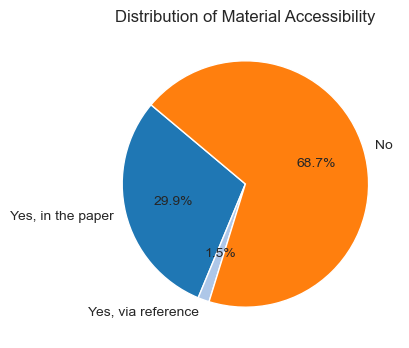

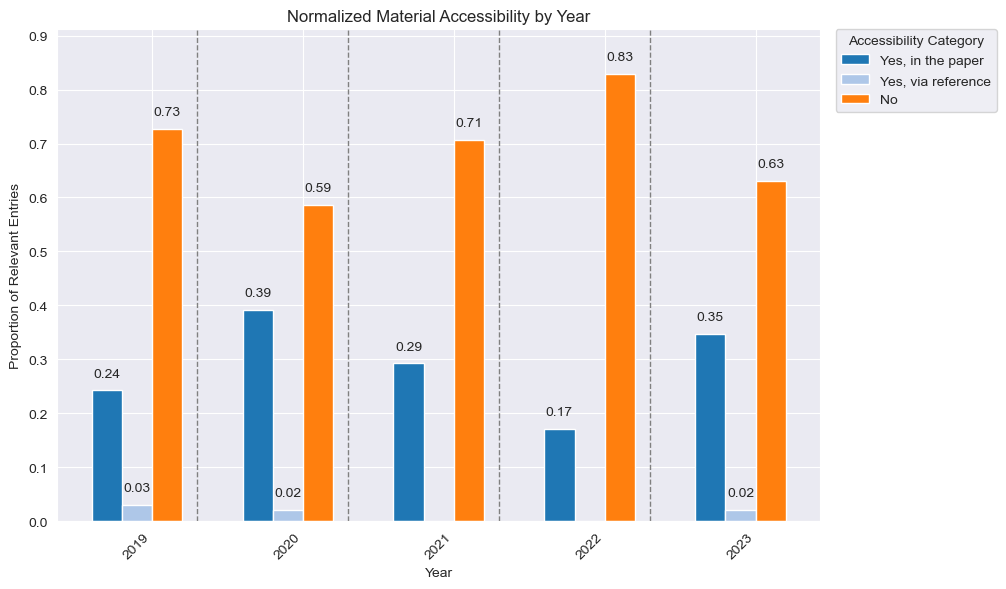

In [157]:
# List of categories
accessibility_categories = [
    "Yes, in the paper",
    "Yes, via reference",
    "No"
]

# Initialize Counter per year
accessibility_year_counts = {category: Counter() for category in accessibility_categories}
total_relevant_entries_per_year = Counter()

# Count occurrences per year
for _, row in data.dropna(subset=['Jahr']).iterrows():
    year = int(row['Jahr'])

    # Count relevant entries (non-empty values in ‘Type of artefact 1’ and ‘Type of artefact 2’)
    relevant_entry = False
    if pd.notna(row['Type of Artefact 1']):
        total_relevant_entries_per_year[year] += 1
        relevant_entry = True
    if pd.notna(row['Type of Artefact 2']):
        total_relevant_entries_per_year[year] += 1
        relevant_entry = True

    if not relevant_entry:
        continue

    # 'Material accessibility' processing
    if pd.isna(row['Material accessibility']) and pd.notna(row['Type of Artefact 1']):
        accessibility_year_counts["No"][year] += 1  # Treat None as No
    elif row['Material accessibility'] in accessibility_categories:
        accessibility_year_counts[row['Material accessibility']][year] += 1

    # 'Material accessibility.1' processing
    if pd.isna(row['Material accessibility.1']) and pd.notna(row['Type of Artefact 2']):
        accessibility_year_counts["No"][year] += 1  # Treat None as No
    elif row['Material accessibility.1'] in accessibility_categories:
        accessibility_year_counts[row['Material accessibility.1']][year] += 1

# Convert to DataFrame for easier plotting
df_counts = pd.DataFrame(accessibility_year_counts).fillna(0).astype(int)
df_counts = df_counts.T  # Transpose to have categories as index and years as columns

# Sort years
df_counts = df_counts[sorted(df_counts.columns)]

# Convert total relevant entries per year to DataFrame
df_total_relevant = pd.DataFrame.from_dict(total_relevant_entries_per_year, orient='index', columns=['Total Relevant']).sort_index()

# Normalize values
df_normalized = df_counts.div(df_total_relevant['Total Relevant'], axis=1).fillna(0)

# Pie chart (overall distribution)
plt.figure(figsize=(4, 4))
total_counts = df_counts.sum(axis=1)
colors = plt.cm.tab20.colors[:len(accessibility_categories)]
plt.pie(total_counts, labels=accessibility_categories, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Distribution of Material Accessibility")
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

# Bar chart (normalized)
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2  # Adjust bar width
years = df_normalized.columns.tolist()
x = np.arange(len(years))  # X positions for years

# Plot bars for each category (normalized values)
for i, category in enumerate(accessibility_categories):
    bars = ax.bar(x + i * bar_width - (len(accessibility_categories) * bar_width) / 2, df_normalized.loc[category],
                  width=bar_width, label=category, color=colors[i])

    # Add labels above bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}",
                    ha="center", va="bottom", fontsize=10)

# Adjust y-axis limit to make space for labels
ax.set_ylim(0, df_normalized.max().max() * 1.1)
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False))  # Allow decimal ticks

# Add vertical dashed lines to separate year groups
for i in range(len(years) - 1):  # Exclude last year
    last_bar_position = x[i] + (len(accessibility_categories) - 1) * bar_width / 2 + bar_width / 2
    ax.axvline(x=last_bar_position, color='gray', linestyle='dashed', linewidth=1)

# Add labels
ax.set_xticks(x)
ax.set_xticklabels(years, rotation=45, ha="right")
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of Relevant Entries")
ax.set_title("Normalized Material Accessibility by Year")
ax.legend(title="Accessibility Category", loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make space for legend
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

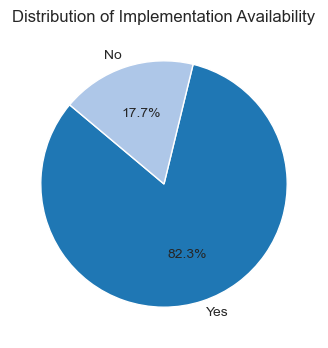

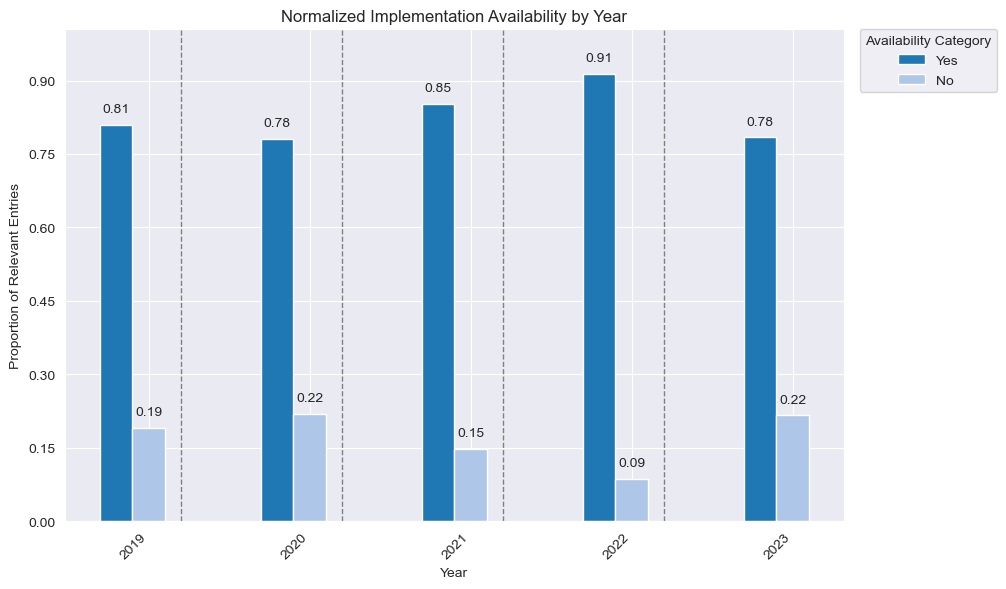

In [158]:
# List of categories
availability_categories = [
    "Yes",
    "No"
]

# Initialize Counter per year
availability_year_counts = {category: Counter() for category in availability_categories}
total_relevant_entries_per_year = Counter()

for _, row in data.dropna(subset=['Jahr']).iterrows():
    year = int(row['Jahr'])

    # Existence
    if pd.notna(row['Existence']) and row['Existence'] == "Yes":
        total_relevant_entries_per_year[year] += 1

        if pd.isna(row['Availability']) and pd.notna(row['Type of Artefact 1']):
            availability_year_counts["No"][year] += 1
        elif row['Availability'] in availability_categories:
            availability_year_counts[row['Availability']][year] += 1

    # Existence.1
    if pd.notna(row['Existence.1']) and row['Existence.1'] == "Yes":
        total_relevant_entries_per_year[year] += 1

        if pd.isna(row['Availability.1']) and pd.notna(row['Type of Artefact 2']):
            availability_year_counts["No"][year] += 1
        elif row['Availability.1'] in availability_categories:
            availability_year_counts[row['Availability.1']][year] += 1


# Convert to DataFrame for easier plotting
df_counts = pd.DataFrame(availability_year_counts).fillna(0).astype(int)
df_counts = df_counts.T  # Transpose to have categories as index and years as columns

# Sort years
df_counts = df_counts[sorted(df_counts.columns)]

# Convert total relevant entries per year to DataFrame
df_total_relevant = pd.DataFrame.from_dict(total_relevant_entries_per_year, orient='index', columns=['Total Relevant']).sort_index()

# Normalize values
df_normalized = df_counts.div(df_total_relevant['Total Relevant'], axis=1).fillna(0)

# Pie chart (overall distribution)
plt.figure(figsize=(4, 4))
total_counts = df_counts.sum(axis=1)
colors = plt.cm.tab20.colors[:len(availability_categories)]
plt.pie(total_counts, labels=availability_categories, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Distribution of Implementation Availability")
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()

# Bar chart (normalized)
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2  # Adjust bar width
years = df_normalized.columns.tolist()
x = np.arange(len(years))  # X positions for years

# Plot bars for each category (normalized values)
for i, category in enumerate(availability_categories):
    bars = ax.bar(x + i * bar_width - (len(availability_categories) * bar_width) / 2, df_normalized.loc[category],
                  width=bar_width, label=category, color=colors[i])

    # Add labels above bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}",
                    ha="center", va="bottom", fontsize=10)

# Adjust y-axis limit to make space for labels
ax.set_ylim(0, df_normalized.max().max() * 1.1)
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False))  # Allow decimal ticks

# Add vertical dashed lines to separate year groups
for i in range(len(years) - 1):  # Exclude last year
    last_bar_position = x[i] + (len(availability_categories) - 1) * bar_width / 2 + bar_width / 2
    ax.axvline(x=last_bar_position, color='gray', linestyle='dashed', linewidth=1)

# Add labels
ax.set_xticks(x)
ax.set_xticklabels(years, rotation=45, ha="right")
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of Relevant Entries")
ax.set_title("Normalized Implementation Availability by Year")
ax.legend(title="Availability Category", loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make space for legend
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()


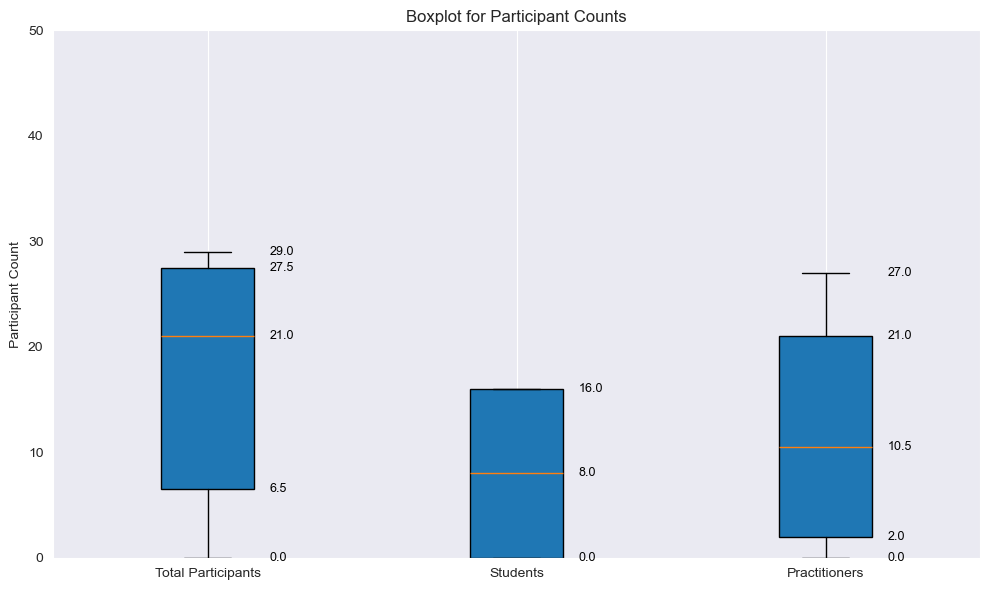

In [159]:
# Function to clean numeric values by removing inequality symbols
def clean_numeric(entry):
    if isinstance(entry, str):
        entry = entry.lstrip('<>=').strip()
    try:
        return float(entry)
    except ValueError:
        return None

# Clean the columns
columns_to_clean = [
    'Total participants count', 'Total participants count.1',
    'Students Count', 'Students Count.1',
    'Practitioners Count', 'Practitioners Count.1'
]
for col in columns_to_clean:
    data[col] = data[col].apply(clean_numeric)

# Group data for combined boxplots
grouped_data = [
    data[['Total participants count', 'Total participants count.1']].dropna().values.flatten(),
    data[['Students Count', 'Students Count.1']].dropna().values.flatten(),
    data[['Practitioners Count', 'Practitioners Count.1']].dropna().values.flatten()
]

# Labels for groups
labels = ['Total Participants', 'Students', 'Practitioners']

# Create the boxplot
plt.figure(figsize=(10, 6))
box = plt.boxplot(grouped_data, patch_artist=True, tick_labels=labels, showfliers=True)

# Customize the plot
plt.title('Boxplot for Participant Counts')
plt.ylabel('Participant Count')
plt.ylim(0, 50)
plt.grid(axis='y')

# Add numeric labels to boxplot, to the right side of each box
for i, group in enumerate(grouped_data):
    stats = np.percentile(group, [25, 50, 75])
    q1, med, q3 = stats
    iqr = q3 - q1
    lower_whisker = np.min(group[group >= q1 - 1.5 * iqr])
    upper_whisker = np.max(group[group <= q3 + 1.5 * iqr])

    # Prepare unique rounded values and their positions
    value_positions = {
        round(lower_whisker, 1): lower_whisker,
        round(q1, 1): q1,
        round(med, 1): med,
        round(q3, 1): q3,
        round(upper_whisker, 1): upper_whisker,
    }

    # Remove duplicates: only unique rounded values shown
    unique_vals = {}
    for rounded_val, true_val in value_positions.items():
        if rounded_val not in unique_vals:
            unique_vals[rounded_val] = true_val

    # Plot each label to the right of the boxplot
    for j, (val_str, y_pos) in enumerate(sorted(unique_vals.items(), key=lambda x: x[1])):
        plt.text(i + 1.2, y_pos, f'{val_str:.1f}', va='center', fontsize=9, color='black')

# Save and show the plot
plt.tight_layout()
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()


--- Gefilterte Students Proportions ---
[0.3695652173913043, 0.0, 0.5517241379310345, 0.5517241379310345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5384615384615384, 0.0, 0.0]

--- Gefilterte Practitioners Proportions ---
[1.0, 0.15217391304347827, 1.0, 1.0, 0.4482758620689655, 0.4482758620689655, 1.0, 1.0, 1.0, 1.0, 0.5405405405405406, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.15384615384615385, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

--- Boxplot Stats (xpos=1) ---
Q1: 0.0, Median: 0.0, Q3: 0.41178929765886285, IQR: 0.41178929765886285
Lower candidates: [0.3695652173913043, 0.0, 0.5517241379310345, 0.5517241379310345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5384615384615384, 0.0, 0.0]
Upper candidates: [0.3695652173913043, 0.0, 0.5517241379310345, 0.5517241379310345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5384615384615384, 0.0, 0.0]
Lower Whisker: 0.0
Upper Whisker: 0.5517241379310345
Plottable Values (xpos=1): {0.0: np.float64(0.0), np.float64(0.412): np.float64(0.41178929765886285), 0.552: 0.55172413

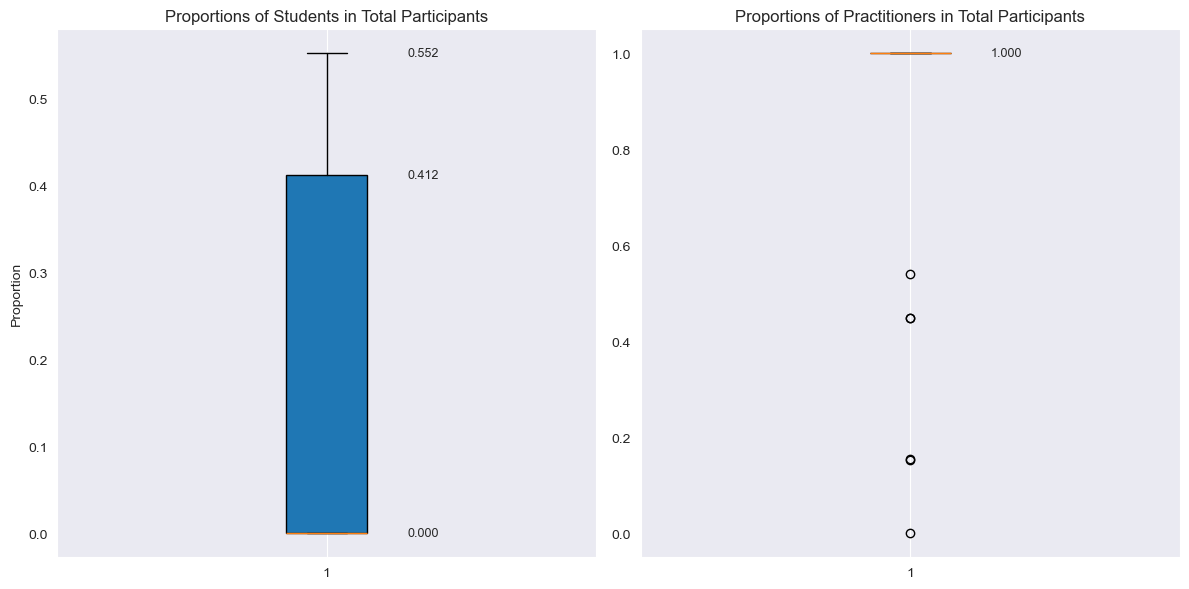

In [160]:
# Function to clean numeric values by removing inequality symbols
def clean_numeric(entry):
    if isinstance(entry, str):
        entry = entry.lstrip('<>=').strip()
    try:
        return float(entry)
    except ValueError:
        return None

columns_to_clean = [
    'Total participants count', 'Total participants count.1',
    'Students Count', 'Students Count.1',
    'Practitioners Count', 'Practitioners Count.1'
]
data[columns_to_clean] = data[columns_to_clean].map(clean_numeric)

# Proportion calculation
def calculate_individual_proportion(row, total_col, count_col):
    total = row[total_col]
    count = row[count_col]
    if total is not None and total > 0 and count is not None:
        return count / total
    return None

students_proportions = []
practitioners_proportions = []

for _, row in data.iterrows():
    for t_col, s_col in [('Total participants count', 'Students Count'),
                         ('Total participants count.1', 'Students Count.1')]:
        sp = calculate_individual_proportion(row, t_col, s_col)
        if sp is not None:
            students_proportions.append(sp)

    for t_col, p_col in [('Total participants count', 'Practitioners Count'),
                         ('Total participants count.1', 'Practitioners Count.1')]:
        pp = calculate_individual_proportion(row, t_col, p_col)
        if pp is not None:
            practitioners_proportions.append(pp)

# Remove NaNs
students_proportions = [p for p in students_proportions if not np.isnan(p)]
practitioners_proportions = [p for p in practitioners_proportions if not np.isnan(p)]

print("\n--- Gefilterte Students Proportions ---")
print(students_proportions)
print("\n--- Gefilterte Practitioners Proportions ---")
print(practitioners_proportions)

# Function for labelling the box plots
def annotate_boxplot(ax, data, xpos):
    if len(data) == 0:
        print(f"⚠️ Keine Daten zum Annotieren für Position {xpos}")
        return

    stats = np.percentile(data, [25, 50, 75])
    q1, med, q3 = stats
    iqr = q3 - q1

    print(f"\n--- Boxplot Stats (xpos={xpos}) ---")
    print(f"Q1: {q1}, Median: {med}, Q3: {q3}, IQR: {iqr}")

    lower_candidates = [x for x in data if x >= q1 - 1.5 * iqr]
    upper_candidates = [x for x in data if x <= q3 + 1.5 * iqr]

    print(f"Lower candidates: {lower_candidates}")
    print(f"Upper candidates: {upper_candidates}")

    lw = min(lower_candidates) if lower_candidates else q1
    uw = max(upper_candidates) if upper_candidates else q3

    print(f"Lower Whisker: {lw}")
    print(f"Upper Whisker: {uw}")

    value_map = {
        round(lw, 3): lw,
        round(q1, 3): q1,
        round(med, 3): med,
        round(q3, 3): q3,
        round(uw, 3): uw,
    }

    unique_values = {}
    for rounded, true in value_map.items():
        if rounded not in unique_values:
            unique_values[rounded] = true

    print(f"Plottable Values (xpos={xpos}): {unique_values}")

    for label_val, y_val in sorted(unique_values.items(), key=lambda x: x[1]):
        ax.text(xpos + 0.15, y_val, f"{label_val:.3f}", va='center', fontsize=9)

# plot
plt.figure(figsize=(12, 6))

# Boxplot: Students
ax1 = plt.subplot(1, 2, 1)
ax1.boxplot(students_proportions, patch_artist=True)
annotate_boxplot(ax1, students_proportions, xpos=1)
ax1.set_title("Proportions of Students in Total Participants")
ax1.set_ylabel("Proportion")
ax1.grid(axis='y')

# Boxplot: Practitioners
ax2 = plt.subplot(1, 2, 2)
ax2.boxplot(practitioners_proportions, patch_artist=True)
annotate_boxplot(ax2, practitioners_proportions, xpos=1)
ax2.set_title("Proportions of Practitioners in Total Participants")
ax2.grid(axis='y')

# Save and display plot
plt.tight_layout()
fig = plt.gcf()
title = fig._suptitle.get_text() if fig._suptitle else fig.axes[0].get_title()
fig.savefig(f"plots/{title.replace(' ', '_').replace('/', '-').replace(':', '-')}.png", bbox_inches='tight', dpi=300)
plt.show()